# Table of Contents
* [1. DDoS Detection on IoT - Unique Model - L5](#1.-DDoS-Detection-on-IoT---Unique-Model---L5)
	* [1.1 Imports](#1.1-Imports)
* [2. Import Datasets and Normalize](#2.-Import-Datasets-and-Normalize)
	* [2.1 Danmini Doorbell](#2.1-Danmini-Doorbell)
	* [2.2 Ecobee Thermostat](#2.2-Ecobee-Thermostat)
	* [2.3 Ennio Doorbell](#2.3-Ennio-Doorbell)
	* [2.4 Philips Baby Monitor](#2.4-Philips-Baby-Monitor)
	* [2.5 Security Camera](#2.5-Security-Camera)
	* [2.6 Security Camera](#2.6-Security-Camera)
	* [2.7 Security Camera](#2.7-Security-Camera)
	* [2.8 Security Camera](#2.8-Security-Camera)
	* [2.9 Samsung Webcam](#2.9-Samsung-Webcam)
* [3. Variational Autoencoder - Attack Detection](#3.-Variational-Autoencoder---Attack-Detection)
	* [3.1 Model](#3.1-Model)
	* [3.2 Train](#3.2-Train)
	* [3.3 Test](#3.3-Test)
	* [3.4 Metrics](#3.4-Metrics)


# 1. DDoS Detection on IoT - Unique Model - L5 - 23 Features - 10 % Data Training - VAE

## 1.1 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

2023-05-05 13:03:47.594817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 13:03:47.808299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 13:03:47.810410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 13:03:48.850138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Import Datasets and Normalize

## 2.1 Danmini Doorbell

In [2]:
# Benign traffic

dd_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

columns = list(df_dd_benign.columns)
chosen_columns = []

for column in columns:
    if column.find('L5') != -1:             # selecionando apenas intervalo L5 (100 ms)
        chosen_columns.append(column)

df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)

# Mirai attacks
dd_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite attacks
dd_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [3]:
df_dd_benign.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,H_L5_weight,H_L5_mean,H_L5_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,...,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,60.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000005,1.000000,354.000000,0.002143,354.000000,...,1.000000,4.980575e+00,4.230000e-07,1.000000,354.000000,0.002143,354.000000,0.000005,0.0,0.0
2,1.857879,360.458980,35.789338,1.857879,360.458979,35.789342,1.857879,360.458979,5.982419,360.458979,...,1.857879,2.323596e+00,6.056226e+00,1.857879,360.458979,5.982419,360.458979,35.789342,0.0,0.0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,337.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0
4,1.680223,172.140917,18487.448750,1.680223,172.140917,18487.448750,1.000000,60.000000,0.000000,524.399648,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0


In [4]:
scaler = MinMaxScaler()

df_dd_benign_norm = scaler.fit_transform(df_dd_benign)
df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

## 2.2 Ecobee Thermostat

In [5]:
# Benign traffic

et_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_et_benign = et_benign.copy(deep=True)
df_et_benign = pd.DataFrame(df_et_benign, columns = chosen_columns)

# Mirai

et_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_ack = et_mirai_ack.copy(deep=True)
df_et_mirai_ack = pd.DataFrame(df_et_mirai_ack, columns = chosen_columns)

et_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_scan = et_mirai_scan.copy(deep=True)
df_et_mirai_scan = pd.DataFrame(df_et_mirai_scan, columns = chosen_columns)

et_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_syn = et_mirai_syn.copy(deep=True)
df_et_mirai_syn = pd.DataFrame(df_et_mirai_syn, columns = chosen_columns)

et_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udp = et_mirai_udp.copy(deep=True)
df_et_mirai_udp = pd.DataFrame(df_et_mirai_udp, columns = chosen_columns)

et_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udpplain = et_mirai_udpplain.copy(deep=True)
df_et_mirai_udpplain = pd.DataFrame(df_et_mirai_udpplain, columns = chosen_columns)

# Bashlite

et_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_combo = et_bashlite_combo.copy(deep=True)
df_et_bashlite_combo = pd.DataFrame(df_et_bashlite_combo, columns = chosen_columns)

et_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_junk = et_bashlite_junk.copy(deep=True)
df_et_bashlite_junk = pd.DataFrame(df_et_bashlite_junk, columns = chosen_columns)

et_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_scan = et_bashlite_scan.copy(deep=True)
df_et_bashlite_scan = pd.DataFrame(df_et_bashlite_scan, columns = chosen_columns)

et_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_udp = et_bashlite_udp.copy(deep=True)
df_et_bashlite_udp = pd.DataFrame(df_et_bashlite_udp, columns = chosen_columns)

et_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_tcp = et_bashlite_tcp.copy(deep=True)
df_et_bashlite_tcp = pd.DataFrame(df_et_bashlite_tcp, columns = chosen_columns)

In [6]:
df_et_benign_norm = scaler.fit_transform(df_et_benign)

df_et_miraiack_norm = scaler.fit_transform(df_et_mirai_ack)
df_et_miraiscan_norm = scaler.fit_transform(df_et_mirai_scan)
df_et_miraisyn_norm = scaler.fit_transform(df_et_mirai_syn)
df_et_miraiudp_norm = scaler.fit_transform(df_et_mirai_udp)
df_et_miraiudpplain_norm = scaler.fit_transform(df_et_mirai_udpplain)

df_et_bashlitecombo_norm = scaler.fit_transform(df_et_bashlite_combo)
df_et_bashlitejunk_norm = scaler.fit_transform(df_et_bashlite_junk)
df_et_bashlitescan_norm = scaler.fit_transform(df_et_bashlite_scan)
df_et_bashliteudp_norm = scaler.fit_transform(df_et_bashlite_udp)
df_et_bashlitetcp_norm = scaler.fit_transform(df_et_bashlite_tcp)

## 2.3 Ennio Doorbell

In [7]:
# Benign traffic

ed_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Only Bashlite

ed_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [8]:
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

## 2.4 Philips Baby Monitor

In [9]:
# Benign traffic

pb_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_pb_benign = pb_benign.copy(deep=True)
df_pb_benign = pd.DataFrame(df_pb_benign, columns = chosen_columns)        
        
# Mirai

pb_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_ack = pb_mirai_ack.copy(deep=True)
df_pb_mirai_ack = pd.DataFrame(df_pb_mirai_ack, columns = chosen_columns)

pb_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_scan = pb_mirai_scan.copy(deep=True)
df_pb_mirai_scan = pd.DataFrame(df_pb_mirai_scan, columns = chosen_columns)

pb_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_syn = pb_mirai_syn.copy(deep=True)
df_pb_mirai_syn = pd.DataFrame(df_pb_mirai_syn, columns = chosen_columns)

pb_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udp = pb_mirai_udp.copy(deep=True)
df_pb_mirai_udp = pd.DataFrame(df_pb_mirai_udp, columns = chosen_columns)

pb_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udpplain = pb_mirai_udpplain.copy(deep=True)
df_pb_mirai_udpplain = pd.DataFrame(df_pb_mirai_udpplain, columns = chosen_columns)

# Bashlite

pb_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_combo = pb_bashlite_combo.copy(deep=True)
df_pb_bashlite_combo = pd.DataFrame(df_pb_bashlite_combo, columns = chosen_columns)

pb_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_junk = pb_bashlite_junk.copy(deep=True)
df_pb_bashlite_junk = pd.DataFrame(df_pb_bashlite_junk, columns = chosen_columns)

pb_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_scan = pb_bashlite_scan.copy(deep=True)
df_pb_bashlite_scan = pd.DataFrame(df_pb_bashlite_scan, columns = chosen_columns)

pb_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_udp = pb_bashlite_udp.copy(deep=True)
df_pb_bashlite_udp = pd.DataFrame(df_pb_bashlite_udp, columns = chosen_columns)

pb_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_tcp = pb_bashlite_tcp.copy(deep=True)
df_pb_bashlite_tcp = pd.DataFrame(df_pb_bashlite_tcp, columns = chosen_columns)

In [10]:
df_pb_benign_norm = scaler.fit_transform(df_pb_benign)

df_pb_miraiack_norm = scaler.fit_transform(df_pb_mirai_ack)
df_pb_miraiscan_norm = scaler.fit_transform(df_pb_mirai_scan)
df_pb_miraisyn_norm = scaler.fit_transform(df_pb_mirai_syn)
df_pb_miraiudp_norm = scaler.fit_transform(df_pb_mirai_udp)
df_pb_miraiudpplain_norm = scaler.fit_transform(df_pb_mirai_udpplain)

df_pb_bashlitecombo_norm = scaler.fit_transform(df_pb_bashlite_combo)
df_pb_bashlitejunk_norm = scaler.fit_transform(df_pb_bashlite_junk)
df_pb_bashlitescan_norm = scaler.fit_transform(df_pb_bashlite_scan)
df_pb_bashliteudp_norm = scaler.fit_transform(df_pb_bashlite_udp)
df_pb_bashlitetcp_norm = scaler.fit_transform(df_pb_bashlite_tcp)

## 2.5 Security Camera

In [11]:
# Benign traffic

p7_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)    

# Mirai

p7_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [12]:
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

## 2.6 Security Camera

In [13]:
# Benign traffic

p8_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p8_benign = p8_benign.copy(deep=True)
df_p8_benign = pd.DataFrame(df_p8_benign, columns = chosen_columns)  

# Mirai

p8_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_ack = p8_mirai_ack.copy(deep=True)
df_p8_mirai_ack = pd.DataFrame(df_p8_mirai_ack, columns = chosen_columns) 

p8_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_scan = p8_mirai_scan.copy(deep=True)
df_p8_mirai_scan = pd.DataFrame(df_p8_mirai_scan, columns = chosen_columns) 

p8_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_syn = p8_mirai_syn.copy(deep=True)
df_p8_mirai_syn = pd.DataFrame(df_p8_mirai_syn, columns = chosen_columns) 

p8_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udp = p8_mirai_udp.copy(deep=True)
df_p8_mirai_udp = pd.DataFrame(df_p8_mirai_udp, columns = chosen_columns) 

p8_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udpplain = p8_mirai_udpplain.copy(deep=True)
df_p8_mirai_udpplain = pd.DataFrame(df_p8_mirai_udpplain, columns = chosen_columns) 

# Bashlite

p8_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_combo = p8_bashlite_combo.copy(deep=True)
df_p8_bashlite_combo = pd.DataFrame(df_p8_bashlite_combo, columns = chosen_columns) 

p8_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_junk = p8_bashlite_junk.copy(deep=True)
df_p8_bashlite_junk = pd.DataFrame(df_p8_bashlite_junk, columns = chosen_columns)

p8_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_scan = p8_bashlite_scan.copy(deep=True)
df_p8_bashlite_scan = pd.DataFrame(df_p8_bashlite_scan, columns = chosen_columns)

p8_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_udp = p8_bashlite_udp.copy(deep=True)
df_p8_bashlite_udp = pd.DataFrame(df_p8_bashlite_udp, columns = chosen_columns)

p8_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_tcp = p8_bashlite_tcp.copy(deep=True)
df_p8_bashlite_tcp = pd.DataFrame(df_p8_bashlite_tcp, columns = chosen_columns)

In [14]:
df_p8_benign_norm = scaler.fit_transform(df_p8_benign)

df_p8_miraiack_norm = scaler.fit_transform(df_p8_mirai_ack)
df_p8_miraiscan_norm = scaler.fit_transform(df_p8_mirai_scan)
df_p8_miraisyn_norm = scaler.fit_transform(df_p8_mirai_syn)
df_p8_miraiudp_norm = scaler.fit_transform(df_p8_mirai_udp)
df_p8_miraiudpplain_norm = scaler.fit_transform(df_p8_mirai_udpplain)

df_p8_bashlitecombo_norm = scaler.fit_transform(df_p8_bashlite_combo)
df_p8_bashlitejunk_norm = scaler.fit_transform(df_p8_bashlite_junk)
df_p8_bashlitescan_norm = scaler.fit_transform(df_p8_bashlite_scan)
df_p8_bashliteudp_norm = scaler.fit_transform(df_p8_bashlite_udp)
df_p8_bashlitetcp_norm = scaler.fit_transform(df_p8_bashlite_tcp)

## 2.7 Security Camera

In [15]:
# Benign traffic

s2_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)
df_s2_benign = pd.DataFrame(df_s2_benign, columns = chosen_columns)  

# Mirai

s2_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)
df_s2_mirai_ack = pd.DataFrame(df_s2_mirai_ack, columns = chosen_columns)

s2_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)
df_s2_mirai_scan = pd.DataFrame(df_s2_mirai_scan, columns = chosen_columns)

s2_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)
df_s2_mirai_syn = pd.DataFrame(df_s2_mirai_syn, columns = chosen_columns)

s2_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)
df_s2_mirai_udp = pd.DataFrame(df_s2_mirai_udp, columns = chosen_columns)

s2_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)
df_s2_mirai_udpplain = pd.DataFrame(df_s2_mirai_udpplain, columns = chosen_columns)

# Bashlite

s2_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)
df_s2_bashlite_combo = pd.DataFrame(df_s2_bashlite_combo, columns = chosen_columns)

s2_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)
df_s2_bashlite_junk = pd.DataFrame(df_s2_bashlite_junk, columns = chosen_columns)

s2_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)
df_s2_bashlite_scan = pd.DataFrame(df_s2_bashlite_scan, columns = chosen_columns)

s2_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)
df_s2_bashlite_udp = pd.DataFrame(df_s2_bashlite_udp, columns = chosen_columns)

s2_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_tcp.copy(deep=True)
df_s2_bashlite_tcp = pd.DataFrame(df_s2_bashlite_tcp, columns = chosen_columns)

In [16]:
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

## 2.8 Security Camera

In [17]:
# Benign traffic

s3_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s3_benign = s3_benign.copy(deep=True)
df_s3_benign = pd.DataFrame(df_s3_benign, columns = chosen_columns)

# Mirai

s3_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_ack = s3_mirai_ack.copy(deep=True)
df_s3_mirai_ack = pd.DataFrame(df_s3_mirai_ack, columns = chosen_columns)

s3_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_scan = s3_mirai_scan.copy(deep=True)
df_s3_mirai_scan = pd.DataFrame(df_s3_mirai_scan, columns = chosen_columns)

s3_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_syn = s3_mirai_syn.copy(deep=True)
df_s3_mirai_syn = pd.DataFrame(df_s3_mirai_syn, columns = chosen_columns)

s3_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udp = s3_mirai_udp.copy(deep=True)
df_s3_mirai_udp = pd.DataFrame(df_s3_mirai_udp, columns = chosen_columns)

s3_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udpplain = s3_mirai_udpplain.copy(deep=True)
df_s3_mirai_udpplain = pd.DataFrame(df_s3_mirai_udpplain, columns = chosen_columns)

# Bashlite

s3_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_combo = s3_bashlite_combo.copy(deep=True)
df_s3_bashlite_combo = pd.DataFrame(df_s3_bashlite_combo, columns = chosen_columns)

s3_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_junk = s3_bashlite_junk.copy(deep=True)
df_s3_bashlite_junk = pd.DataFrame(df_s3_bashlite_junk, columns = chosen_columns)

s3_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_scan = s3_bashlite_scan.copy(deep=True)
df_s3_bashlite_scan = pd.DataFrame(df_s3_bashlite_scan, columns = chosen_columns)

s3_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_udp = s3_bashlite_udp.copy(deep=True)
df_s3_bashlite_udp = pd.DataFrame(df_s3_bashlite_udp, columns = chosen_columns)

s3_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_tcp = s3_bashlite_tcp.copy(deep=True)
df_s3_bashlite_tcp = pd.DataFrame(df_s3_bashlite_tcp, columns = chosen_columns)

In [18]:
df_s3_benign_norm = scaler.fit_transform(df_s3_benign)

df_s3_miraiack_norm = scaler.fit_transform(df_s3_mirai_ack)
df_s3_miraiscan_norm = scaler.fit_transform(df_s3_mirai_scan)
df_s3_miraisyn_norm = scaler.fit_transform(df_s3_mirai_syn)
df_s3_miraiudp_norm = scaler.fit_transform(df_s3_mirai_udp)
df_s3_miraiudpplain_norm = scaler.fit_transform(df_s3_mirai_udpplain)

df_s3_bashlitecombo_norm = scaler.fit_transform(df_s3_bashlite_combo)
df_s3_bashlitejunk_norm = scaler.fit_transform(df_s3_bashlite_junk)
df_s3_bashlitescan_norm = scaler.fit_transform(df_s3_bashlite_scan)
df_s3_bashliteudp_norm = scaler.fit_transform(df_s3_bashlite_udp)
df_s3_bashlitetcp_norm = scaler.fit_transform(df_s3_bashlite_tcp)

## 2.9 Samsung Webcam

In [19]:
# Benign traffic

sw_benign = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_sw_benign = sw_benign.copy(deep=True)
df_sw_benign = pd.DataFrame(df_sw_benign, columns = chosen_columns)

# Bashlite Only

sw_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_combo = sw_bashlite_combo.copy(deep=True)
df_sw_bashlite_combo = pd.DataFrame(df_sw_bashlite_combo, columns = chosen_columns)

sw_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_junk = sw_bashlite_junk.copy(deep=True)
df_sw_bashlite_junk = pd.DataFrame(df_sw_bashlite_junk, columns = chosen_columns)

sw_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_scan = sw_bashlite_scan.copy(deep=True)
df_sw_bashlite_scan = pd.DataFrame(df_sw_bashlite_scan, columns = chosen_columns)

sw_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_udp = sw_bashlite_udp.copy(deep=True)
df_sw_bashlite_udp = pd.DataFrame(df_sw_bashlite_udp, columns = chosen_columns)

sw_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10ºPeriodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_tcp = sw_bashlite_tcp.copy(deep=True)
df_sw_bashlite_tcp = pd.DataFrame(df_sw_bashlite_tcp, columns = chosen_columns)

In [20]:
df_sw_benign_norm = scaler.fit_transform(df_sw_benign)

df_sw_bashlitecombo_norm = scaler.fit_transform(df_sw_bashlite_combo)
df_sw_bashlitejunk_norm = scaler.fit_transform(df_sw_bashlite_junk)
df_sw_bashlitescan_norm = scaler.fit_transform(df_sw_bashlite_scan)
df_sw_bashliteudp_norm = scaler.fit_transform(df_sw_bashlite_udp)
df_sw_bashlitetcp_norm = scaler.fit_transform(df_sw_bashlite_tcp)

# 3. Variational Autoencoder - Attack Detection

## 3.1 Model

In [21]:
# Train set
len_dd_benign_train = int(0.1 * len(df_dd_benign_norm))
X_train_dd_benign = df_dd_benign_norm[:len_dd_benign_train]

len_et_benign_train = int(0.1 * len(df_et_benign_norm))
X_train_et_benign = df_et_benign_norm[:len_et_benign_train]

len_ed_benign_train = int(0.1 * len(df_ed_benign_norm))
X_train_ed_benign = df_ed_benign_norm[:len_ed_benign_train]

len_pb_benign_train = int(0.1 * len(df_pb_benign_norm))
X_train_pb_benign = df_pb_benign_norm[:len_pb_benign_train]

len_p7_benign_train = int(0.1 * len(df_p7_benign_norm))
X_train_p7_benign = df_p7_benign_norm[:len_p7_benign_train]

len_p8_benign_train = int(0.1 * len(df_p8_benign_norm))
X_train_p8_benign = df_p8_benign_norm[:len_p8_benign_train]

len_s2_benign_train = int(0.1 * len(df_s2_benign_norm))
X_train_s2_benign = df_s2_benign_norm[:len_s2_benign_train]

len_s3_benign_train = int(0.1 * len(df_s3_benign_norm))
X_train_s3_benign = df_s3_benign_norm[:len_s3_benign_train]

len_sw_benign_train = int(0.1 * len(df_sw_benign_norm))
X_train_sw_benign = df_sw_benign_norm[:len_sw_benign_train]

X_train_VAE = np.concatenate([X_train_dd_benign, X_train_et_benign, X_train_ed_benign, X_train_pb_benign, X_train_p7_benign, 
                              X_train_p8_benign, X_train_s2_benign, X_train_s3_benign])

# Test set - 90% benign and the rest is attack
X_test_dd_benign = df_dd_benign_norm[len_dd_benign_train:]
X_test_et_benign = df_et_benign_norm[len_et_benign_train:]
X_test_ed_benign = df_ed_benign_norm[len_ed_benign_train:]
X_test_pb_benign = df_pb_benign_norm[len_pb_benign_train:]
X_test_p7_benign = df_p7_benign_norm[len_p7_benign_train:]
X_test_p8_benign = df_p8_benign_norm[len_p8_benign_train:]
X_test_s2_benign = df_s2_benign_norm[len_s2_benign_train:]
X_test_s3_benign = df_s3_benign_norm[len_s3_benign_train:]
X_test_sw_benign = df_sw_benign_norm[len_sw_benign_train:]

X_test_benign = np.concatenate([X_test_dd_benign, X_test_et_benign, X_test_ed_benign, X_test_pb_benign, X_test_p7_benign, 
                                X_test_p8_benign, X_test_s2_benign, X_test_s3_benign, X_test_sw_benign])

# 90% benign + attacks
X_test_VAE = np.concatenate([X_test_benign,
                             df_dd_miraiack_norm, df_dd_miraiscan_norm, df_dd_miraisyn_norm, df_dd_miraiudp_norm, df_dd_miraiudpplain_norm,
                             df_dd_bashlitecombo_norm, df_dd_bashlitejunk_norm, df_dd_bashlitescan_norm, df_dd_bashliteudp_norm, df_dd_bashlitetcp_norm,
                             df_et_miraiack_norm, df_et_miraiscan_norm, df_et_miraisyn_norm, df_et_miraiudp_norm, df_et_miraiudpplain_norm,
                             df_et_bashlitecombo_norm, df_et_bashlitejunk_norm, df_et_bashlitescan_norm, df_et_bashliteudp_norm, df_et_bashlitetcp_norm,
                             df_ed_bashlitecombo_norm, df_ed_bashlitejunk_norm, df_ed_bashlitescan_norm, df_ed_bashliteudp_norm, df_ed_bashlitetcp_norm,
                             df_pb_miraiack_norm, df_pb_miraiscan_norm, df_pb_miraisyn_norm, df_pb_miraiudp_norm, df_pb_miraiudpplain_norm,
                             df_pb_bashlitecombo_norm, df_pb_bashlitejunk_norm, df_pb_bashlitescan_norm, df_pb_bashliteudp_norm, df_pb_bashlitetcp_norm,
                             df_p7_miraiack_norm, df_p7_miraiscan_norm, df_p7_miraisyn_norm, df_p7_miraiudp_norm, df_p7_miraiudpplain_norm,
                             df_p7_bashlitecombo_norm, df_p7_bashlitejunk_norm, df_p7_bashlitescan_norm, df_p7_bashliteudp_norm, df_p7_bashlitetcp_norm,
                             df_p8_miraiack_norm, df_p8_miraiscan_norm, df_p8_miraisyn_norm, df_p8_miraiudp_norm, df_p8_miraiudpplain_norm,
                             df_p8_bashlitecombo_norm, df_p8_bashlitejunk_norm, df_p8_bashlitescan_norm, df_p8_bashliteudp_norm, df_p8_bashlitetcp_norm,
                             df_s2_miraiack_norm, df_s2_miraiscan_norm, df_s2_miraisyn_norm, df_s2_miraiudp_norm, df_s2_miraiudpplain_norm,
                             df_s2_bashlitecombo_norm, df_s2_bashlitejunk_norm, df_s2_bashlitescan_norm, df_s2_bashliteudp_norm, df_s2_bashlitetcp_norm,
                             df_s3_miraiack_norm, df_s3_miraiscan_norm, df_s3_miraisyn_norm, df_s3_miraiudp_norm, df_s3_miraiudpplain_norm,
                             df_s3_bashlitecombo_norm, df_s3_bashlitejunk_norm, df_s3_bashlitescan_norm, df_s3_bashliteudp_norm, df_s3_bashlitetcp_norm,
                             df_sw_bashlitecombo_norm, df_sw_bashlitejunk_norm, df_sw_bashlitescan_norm, df_sw_bashliteudp_norm, df_sw_bashlitetcp_norm])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0


In [22]:
Y_test_VAE

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
# KL Loss function
def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all  
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, pushing latent feature space to normality

In [24]:
# Parameters
original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 100
learning_rate = 0.0001          # learning rate
batch_size = 40
anomaly_threshold = 0.05
number_features = 23

In [25]:
# Encoder Model

# The encoder learns a function that takes an input array of size n and can generate two vectors that represents the
# parameters (mean and variance) of a distribution from which the latent vector is sampled.

# encoder(input_vector[]) => latent_v_mu[], latent_v_lvar[]
# So that - latent_v[0] ~  N(latent_v_mu[0], latent_v_lvar[0])
# and latent_v[1] ~  N(latent_v_mu[1], latent_v_lvar[1])

def vae_encoder(input_shape, intermediate_dim, latent_dim, sample):
    inputs = Input(shape = input_shape, name = 'encoder_input')
    x = Dense(intermediate_dim, activation = 'relu')(inputs)

    z_mean = Dense(latent_dim, name = 'z_mean')(x)
    z_var = Dense(latent_dim, name = 'z_var')(x)
    z = Lambda(sample, output_shape = (latent_dim,), name = 'z')([z_mean, z_var])

    encoder = Model(inputs, z, name = 'encoder')
    return inputs, encoder, z_var, z_mean

# Reparameterization trick
def sample(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    
    return z_mean + K.exp(0.5 * z_var) * epsilon

# Sample the normally distributed z - mean + sigma * epsilon. The epsilon ensures the continuity of latent space and helps
# the network to keep correcting its parameters through backpropagation

# Decoder model
def vae_decoder(intermediate_dim, latent_dim, original_dim):
    latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
    x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
    outputs = Dense(original_dim, activation = 'sigmoid')(x)

    # Instantiate the decoder model
    decoder = Model(latent_inputs, outputs, name = 'decoder')

    return decoder

# Transforms the latent feature space composed by distributions of mean and variance back to the original input vector

# Get error term
def get_error_term(v1, v2, _rmse = True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis = 1))
    
    return np.mean(abs(v1 - v2), axis = 1)

# Calculates the error between the original vector and the predicted one

In [26]:
# Encoder
inputs, encoder, z_var, z_mean = vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [27]:
# Decoder
decoder = vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [28]:
# VAE model
outputs = decoder(encoder(inputs))

opt = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss, experimental_run_tf_function=False)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## 3.2 Train

In [29]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)
                        

train_end = time.time()
train_time = train_end - train_start

print("Training time: ", train_time)

Train on 50375 samples
Epoch 1/100


2023-05-05 13:12:02.430888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-05 13:12:02.476696: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/z_mean/bias/m/Assign' id:441 op device:{requested: '', assigned: ''} def:{{{node training/Adam/z_mean/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/z_mean/bias/m, training/Adam/z_mean/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


50375/50375 [==============================] - 1s 26us/sample - loss: 138.1558
Epoch 2/100
50375/50375 [==============================] - 1s 22us/sample - loss: 45.4191
Epoch 3/100
50375/50375 [==============================] - 1s 22us/sample - loss: 22.7423
Epoch 4/100
50375/50375 [==============================] - 1s 22us/sample - loss: 19.3699
Epoch 5/100
50375/50375 [==============================] - 1s 24us/sample - loss: 17.5078
Epoch 6/100
50375/50375 [==============================] - 1s 22us/sample - loss: 15.3986
Epoch 7/100
50375/50375 [==============================] - 1s 21us/sample - loss: 13.4098
Epoch 8/100
50375/50375 [==============================] - 1s 22us/sample - loss: 12.2256
Epoch 9/100
50375/50375 [==============================] - 1s 22us/sample - loss: 11.3667
Epoch 10/100
50375/50375 [==============================] - 1s 22us/sample - loss: 10.7465
Epoch 11/100
50375/50375 [==============================] - 1s 21us/sample - loss: 10.1958
Epoch 12/100
50375/

50375/50375 [==============================] - 1s 21us/sample - loss: 5.6092
Epoch 93/100
50375/50375 [==============================] - 1s 22us/sample - loss: 5.6082
Epoch 94/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5994
Epoch 95/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5737
Epoch 96/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5676
Epoch 97/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5647
Epoch 98/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5591
Epoch 99/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5687
Epoch 100/100
50375/50375 [==============================] - 1s 21us/sample - loss: 5.5513
Training time:  107.98450136184692


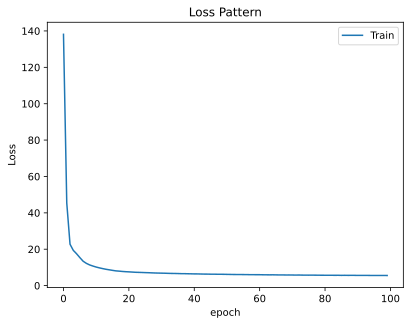

In [30]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## 3.3 Test

In [31]:
# Prediction in Train Data
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

attacks = (error_vector > error_thresh)
print(attacks)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks predicted in training data

2023-05-05 13:15:30.046299: W tensorflow/c/c_api.cc:300] Operation '{name:'decoder/dense_2/Sigmoid' id:178 op device:{requested: '', assigned: ''} def:{{{node decoder/dense_2/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[ True  True  True ... False False  True]


In [33]:
# Prediction in Test Data
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time: ", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks predicted

Testing time:  75.32807326316833
[False False False ...  True  True  True]


0.9365293300314999

In [34]:
# Quantidade real de ataques nos dados de teste
np.count_nonzero(Y_test_VAE==1) / len(Y_test_VAE)

0.928594140501463

In [38]:
# Quantidade dados de treino / teste
print(f'{X_train_VAE.shape} {X_test_VAE.shape}')

(50375, 23) (7007016, 23)


## 3.4 Metrics

In [35]:
target_names = ['Benign', 'Attack']

print(f" ==== Test {number_features} features - Normal learning rate ====")
print(f"Training time: {train_time / 60:.2f} min")
print(f"Testing time: {test_time / 60:.2f} min")
print(classification_report(Y_test_VAE, attacks, target_names=target_names, digits = 5))

 ==== Test 23 features - Normal learning rate ====
Training time: 1.80 min
Testing time: 1.26 min
              precision    recall  f1-score   support

      Benign    0.97793   0.86925   0.92039    500342
      Attack    0.99003   0.99849   0.99424   6506674

    accuracy                        0.98926   7007016
   macro avg    0.98398   0.93387   0.95732   7007016
weighted avg    0.98917   0.98926   0.98897   7007016



[[ 434924   65418]
 [   9816 6496858]]


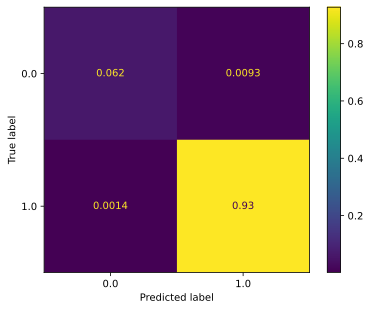

In [36]:
print(confusion_matrix(Y_test_VAE, attacks))
ConfusionMatrixDisplay.from_predictions(Y_test_VAE, attacks, normalize='all')

plt.show()